In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np

### Maths Servers:

In [2]:
import sys
sys.path.append('/home/links/ct715/eddy_feedback/')
import functions.eddy_feedback as ef 
import functions.data_wrangling as data 

# import dataset for maths servers
ds = xr.open_mfdataset('/home/links/ct715/data_storage/reanalysis/srip_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds = data.seasonal_mean(ds, season='djf')
ds = data.check_dimensions(ds, ignore_dim='lon')
ds 

<xarray.Dataset>
Dimensions:  (time: 60, level: 22, lat: 73)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 5.0 3.0 2.0 1.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * time     (time) datetime64[ns] 1957-12-01 1958-12-01 ... 2016-12-01
Data variables:
    ubar     (time, level, lat) float32 5.1e-06 -2.062 ... 8.936 -0.0001013
    div1_pr  (time, level, lat) float32 nan nan nan nan nan ... nan nan nan nan
    div1_qg  (time, level, lat) float32 nan nan -2.372e-05 ... 7.282e-05 nan nan

### JASMIN Servers:

In [3]:
# import sys
# sys.path.append('/home/users/cturrell/documents/eddy_feedback/')
# import functions.eddy_feedback as ef
# import functions.data_wrangling as data 

# # import dataset for JASMIN servers
# ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/srip_datasets/jra55*.nc',
#                             parallel=True, chunks={'time': 31})

# ds = data.seasonal_mean(ds, season='djf')
# ds = data.check_dimensions(ds, ignore_dim='lon')
# ds 

# Zonal-mean zonal wind (DJF)

In [4]:
# define zonal mean zonal wind
u = ds.ubar

# slice data at 500hPA and set EFP boundaries
u = u.sel( level = 500. )
u = u.where( ds.lat >= 25., drop=True )
u = u.where( ds.lat <= 75., drop=True )

# flip axes so time on x-axis
u = u.transpose()

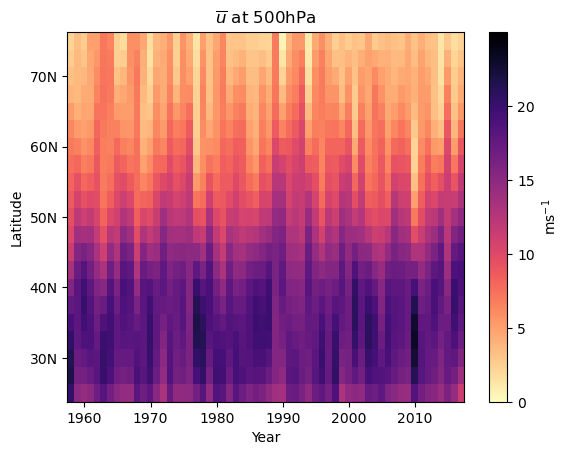

In [5]:
fig, ax = plt.subplots()
u.plot(ax=ax, cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
ax.set_yticks(np.arange(30,80,10))
ax.set_yticklabels(['30N', '40N', '50N', '60N', '70N'])
ax.set_title('$\\overline{u}$ at 500hPa')
ax.set_ylabel('Latitude')
ax.set_xlabel('Year')
plt.show()

# DJF Northward EP Flux Divergence

In [6]:
# separate into interannual means
# div1 = ds.div1_pr / 86400 
div1 = ds.div1_pr

# slice data at 500hPA and set EFP boundaries
div1 = div1.sel( level = 500. )
div1 = div1.where( ds.lat >= 25., drop=True )
div1 = div1.where( ds.lat <= 75., drop=True )

# flip axes so time on x-axis
div1 = div1.transpose()

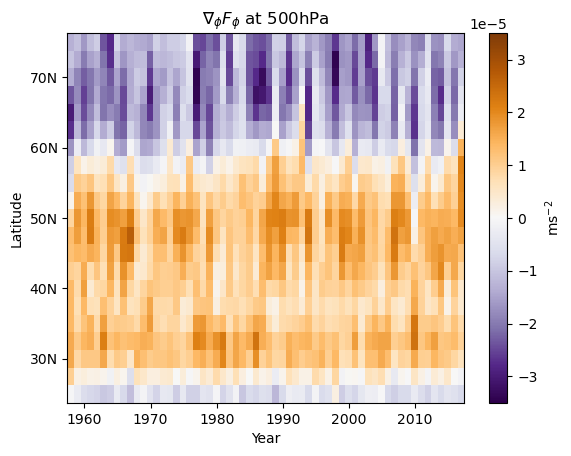

In [7]:
fig, ax = plt.subplots()
div1.plot(ax=ax, cmap='PuOr_r', vmin=-3.5e-5, vmax=3.5e-5,
       cbar_kwargs={'label': 'ms$^{-2}$'})
ax.set_yticks(np.arange(30,80,10))
ax.set_yticklabels(['30N', '40N', '50N', '60N', '70N'])
ax.set_title('$\\nabla_\\phi F_\\phi$ at 500hPa')
ax.set_ylabel('Latitude')
ax.set_xlabel('Year')
plt.show()

# Plot both Figures

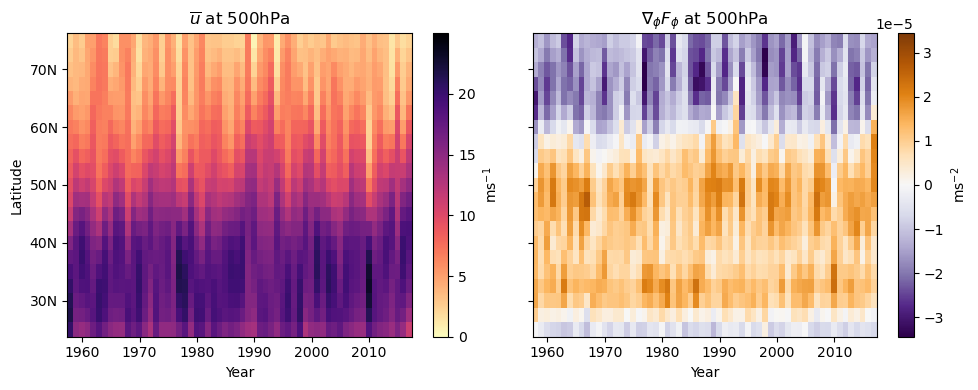

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,4))

# plot ubar 
u.plot(ax=ax1, cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
ax1.set_yticks(np.arange(30,80, 10))
ax1.set_yticklabels(['30N', '40N', '50N', '60N', '70N'])
ax1.set_title('$\\overline{u}$ at 500hPa')
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Year')


# plot div1 
div1.plot(ax=ax2, cmap='PuOr_r',
       cbar_kwargs={'label': 'ms$^{-2}$'})
ax2.set_title('$\\nabla_\\phi F_\\phi$ at 500hPa')
ax2.set_ylabel('')
ax2.set_xlabel('Year')

plt.tight_layout()
plt.show()

# Covariance

In [9]:
uanom = (u- u.mean('time'))
div1anom = (div1- div1.mean('time') )

prod = uanom*div1anom

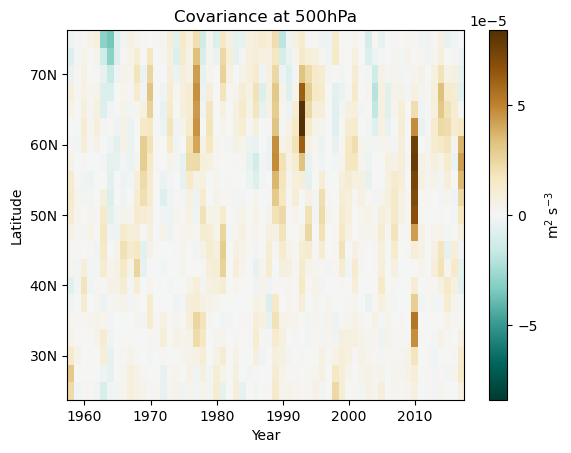

In [10]:
fig, ax = plt.subplots()
prod.plot(ax=ax, cmap='BrBG_r', cbar_kwargs={'label': 'm$^2$ s$^{-3}$', 'ticks':[-5e-5,0,5e-5]})
ax.set_title('Covariance at 500hPa')
ax.set_yticks(np.arange(30,80, 10))
ax.set_yticklabels(['30N', '40N', '50N', '60N', '70N'])
ax.set_ylabel('Latitude')
ax.set_xlabel('Year')
plt.show()

# Correlation

In [11]:
ustd = u.std()
div1std = div1.std()

corr = prod / (ustd * div1std)


In [12]:
# somehow greater than 1????
corr = corr.where( corr < 1)
corr = corr.fillna(1)

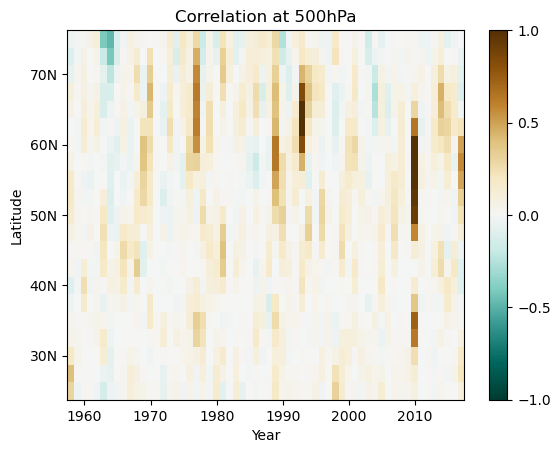

In [13]:
fig, ax = plt.subplots()
corr.plot(ax=ax, cmap='BrBG_r', vmin=-1., vmax=1,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]}) 
ax.set_title('Correlation at 500hPa')
ax.set_yticks(np.arange(30,80, 10))
ax.set_yticklabels(['30N', '40N', '50N', '60N', '70N'])
ax.set_ylabel('Latitude')
ax.set_xlabel('Year')
plt.show()

# Reset data

### JASMIN

In [14]:
# # import dataset for JASMIN servers
# ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/srip_datasets/jra55*.nc',
#                             parallel=True, chunks={'time': 31})

# ds = data.seasonal_mean(ds, season='djf')
# ds = data.check_dimensions(ds, ignore_dim='lon')
# ds

OSError: no files to open

### Maths Servers

In [15]:
ds = xr.open_mfdataset('/home/links/ct715/data_storage/reanalysis/jra55_daily/jra55_ubar_ep-both.nc',
                            parallel=True, chunks={'time': 31})
ds = data.seasonal_mean(ds, season='djf')
ds

<xarray.Dataset>
Dimensions:  (time: 60, level: 37, lat: 73)
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) datetime64[ns] 1957-12-01 1958-12-01 ... 2016-12-01
Data variables:
    ubar     (time, level, lat) float32 4.575e-05 5.409 ... -1.927 -7.069e-06
    div1_pr  (time, level, lat) float64 1.259e+12 5.893 ... 1.372 1.343e+11
    div1_qg  (time, level, lat) float64 1.259e+12 5.862 8.71 ... 1.431 1.343e+11

In [ ]:

ds = ds.sel(level=500.)
ds = ds.sel(lat=slice(75,25))

corr2 = xr.corr(ds.ubar, ds.div1_pr, dim='time')

corr2 

<xarray.DataArray (lat: 0)>
array([], dtype=float64)
Coordinates:
    level    float32 500.0
  * lat      (lat) float32

# Plot all figures

(11.023622047244094, 7.086614173228346)


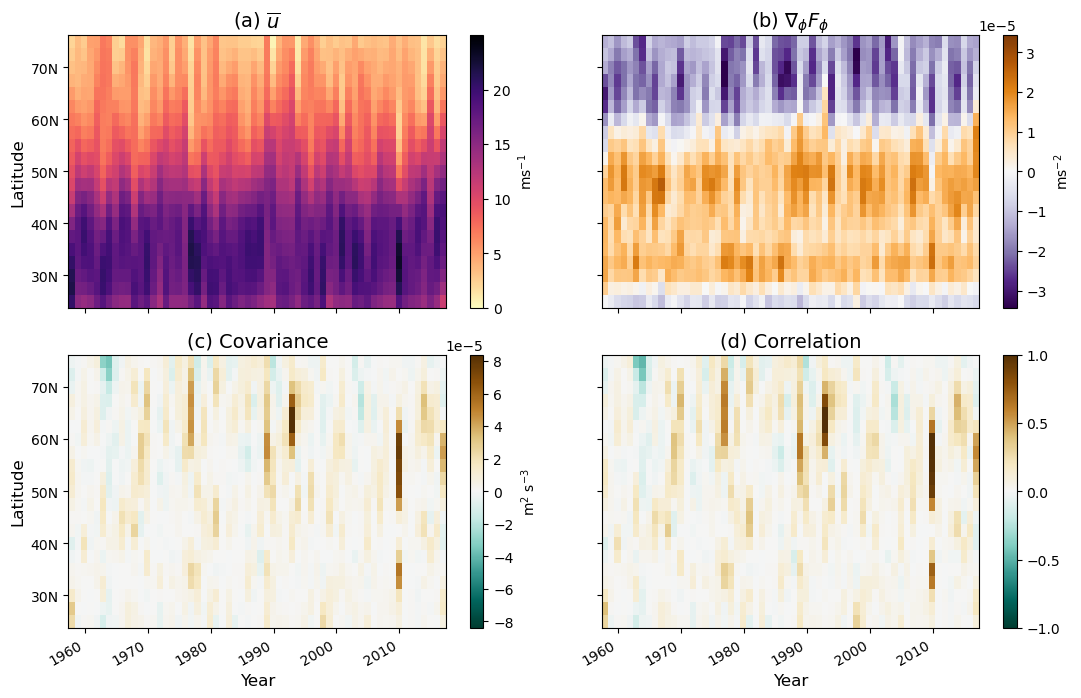

In [ ]:
inches = 1/25.4 

width = 280 #(180/4)*3
height = 180 #(325/4)*3

figsize = (width*inches, height*inches)
print(figsize)

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=figsize)

# plot ubar
u.plot(ax=axs[0,0], cmap='magma_r', vmin=0, vmax=25,
       cbar_kwargs={'label': 'ms$^{-1}$', 'ticks':[0, 5, 10, 15, 20]})
axs[0,0].set_yticks(np.arange(30,80, 10))
axs[0,0].set_yticklabels(['30N', '40N', '50N', '60N', '70N'])
axs[0,0].set_title('(a) $\\overline{u}$', fontsize=14)
axs[0,0].set_ylabel('Latitude', fontsize=12)
axs[0,0].set_xlabel('')


# plot div1
div1.plot(ax=axs[0,1], cmap='PuOr_r',
       cbar_kwargs={'label': 'ms$^{-2}$'})
axs[0,1].set_title('(b) $\\nabla_\\phi F_\\phi$', fontsize=14)
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')

# plot covariance
prod.plot(ax=axs[1,0], cmap='BrBG_r', cbar_kwargs={'label': 'm$^2$ s$^{-3}$'})#, 'ticks':[-5e-5,0,5e-5]})
axs[1,0].set_title('(c) Covariance', fontsize=14)
axs[1,0].set_ylabel('Latitude', fontsize=12)
axs[1,0].set_xlabel('Year', fontsize=12)

# plot correlation
corr.plot(ax=axs[1,1], cmap='BrBG_r', vmin=-1., vmax=1.,
          cbar_kwargs={'ticks':[-1,-0.5,0,0.5,1]})
axs[1,1].set_title('(d) Correlation', fontsize=14)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Year', fontsize=12)

# fig.suptitle('Figure 3: Eddy Feedback Parameter at 500hPa', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
prod.max()